# Synthetic control with sci-kit learn models

In [1]:
import causalpy as cp

## Load data

In [2]:
df = cp.load_data("sc")
treatment_time = 70

## Analyse with `WeightedProportion` model

In [3]:
# Note, we do not want an intercept in this model
result = cp.SyntheticControl(
    df,
    treatment_time,
    formula="actual ~ 0 + a + b + c + d + e + f + g",
    model=cp.skl_models.WeightedProportion(),
)

In [4]:
fig, ax = result.plot(plot_predictors=True)

TypeError: PrePostFit.plot() got an unexpected keyword argument 'plot_predictors'

In [5]:
result.plot_coeffs()

AttributeError: 'SyntheticControl' object has no attribute 'plot_coeffs'

In [6]:
result.summary(round_to=3)

==================================Pre-Post Fit==================================
Formula: actual ~ 0 + a + b + c + d + e + f + g
Model coefficients:
  a	     0.385
  b	     0.172
  c	     0.443
  d	         0
  e	  5.39e-18
  f	         0
  g	         0


But we can see that (for this dataset) these estimates are quite bad. So we can lift the "sum to 1" assumption and instead use the `LinearRegression` model, but still constrain weights to be positive. Equally, you could experiment with the `Ridge` model (e.g. `Ridge(positive=True, alpha=100)`).

## Analyse with the `LinearRegression` model

In [7]:
# Note, we do not want an intercept in this model
result = cp.SyntheticControl(
    df,
    treatment_time,
    formula="actual ~ 0 + a + b + c + d + e + f + g",
    model=cp.skl_models.LinearRegression(positive=True),
)

OLSPlotComponent - plot_pre_post


ValueError: x and y must have same first dimension, but have shapes (30,) and (900,)

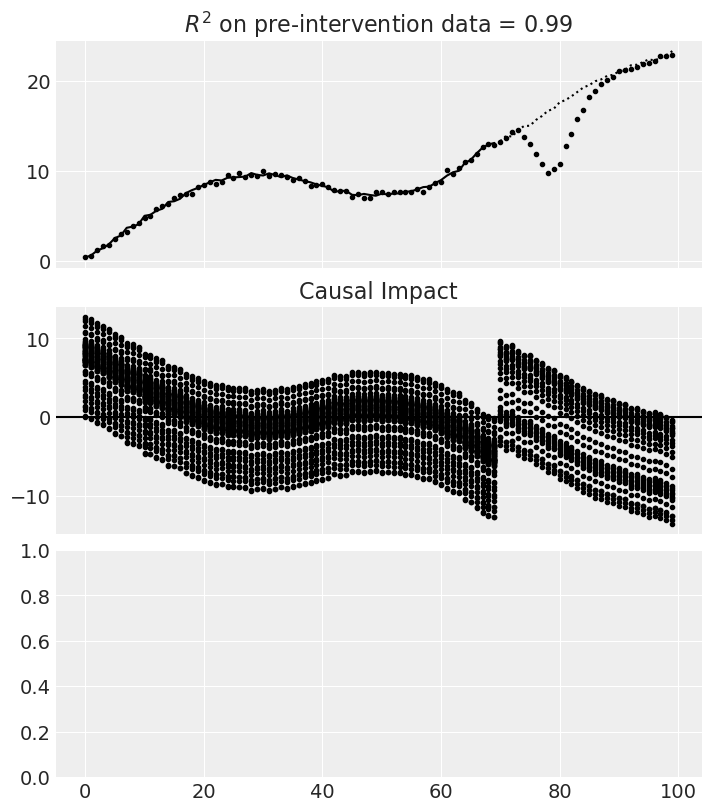

In [8]:
fig, ax = result.plot()

In [9]:
result.plot_coeffs()

AttributeError: 'SyntheticControl' object has no attribute 'plot_coeffs'

In [10]:
result.summary(round_to=3)

==================================Pre-Post Fit==================================
Formula: actual ~ 0 + a + b + c + d + e + f + g
Model coefficients:
  a	     0.322
  b	    0.0581
  c	     0.288
  d	    0.0561
  e	   0.00418
  f	     0.229
  g	    0.0378
